In [17]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

current_working_directory = os.getcwd()
print(f"현재 파이썬 코드가 실행되는 디렉토리: {current_working_directory}\n")

file_path_relative = 'olist_orders_dataset.csv'
df = pd.read_csv(file_path_relative, encoding='ISO-8859-1')

display(df.head())

# orders 데이터 탐색 : 누락, 중복, 이상
df.describe()
df.info()

현재 파이썬 코드가 실행되는 디렉토리: c:\Users\mumu1\Desktop\project_movie_data



FileNotFoundError: [Errno 2] No such file or directory: 'olist_orders_dataset.csv'

In [ ]:
%pip install pandas-summary

  Using cached pandas_summary-0.2.0-py2.py3-none-any.whl.metadata (598 bytes)
  Using cached datatile-1.0.3-py3-none-any.whl.metadata (1.3 kB)
  Using cached traceml-1.0.8-py3-none-any.whl.metadata (11 kB)
Using cached pandas_summary-0.2.0-py2.py3-none-any.whl (5.2 kB)
Using cached datatile-1.0.3-py3-none-any.whl (6.0 kB)
Using cached traceml-1.0.8-py3-none-any.whl (144 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# from pandas_summary import DataFrameSummary
# # 프로파일링
# dfs = DataFrameSummary(df)
# print(dfs.summary())

In [ ]:
df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
# 결측치 삭제
df_order = df.copy()
df_order = df_order.dropna(inplace=True)

# 이상치 탐지: 계산한 배송시간 차이가 크거나 작은 경우
print('\n=== 이상값 확인 ===')

# 데이터 타입 변환
df_order["order_approved_at"] = pd.to_datetime(df_order["order_approved_at"])
df_order["order_purchase_timestamp"] = pd.to_datetime(df_order["order_purchase_timestamp"])
df_order["order_delivered_carrier_date"] = pd.to_datetime(df_order["order_delivered_carrier_date"])
df_order["order_delivered_customer_date"] = pd.to_datetime(df_order["order_delivered_customer_date"])
df_order["order_purchase_timestamp"] = pd.to_datetime(df_order["order_purchase_timestamp"])

# 시간 차이 계산 (일 단위)
# 결제까지 걸린 시간: 주문승인일 - 결제일
df_order["purchase_to_approved"] = (df_order["order_approved_at"] - df_order["order_purchase_timestamp"]).dt.total_seconds()/86400
# 주문-배송 걸린 시간: 배송완료일 - 주문승인일
df_order["approved_to_carrier"] = (df_order["order_delivered_carrier_date"] - df_order["order_approved_at"]).dt.total_seconds()/86400
# 택배사-배송 걸린 시간: 배송완료일 - 택배사 전달일
df_order["carrier_to_customer"] = (df_order["order_delivered_customer_date"] - df_order["order_delivered_carrier_date"]).dt.total_seconds()/86400
# 계산-배송 걸린 시간: - 배송완료일 - 주문계산일
df_order["purchase_to_customer"] = (df_order["order_delivered_customer_date"] - df_order["order_purchase_timestamp"]).dt.total_seconds()/86400

# 모든 시간 계산 컬럼에서 음수 값만 찾기
# 시간 계산 컬럼 리스트
time_cols = ["purchase_to_approved","approved_to_carrier","carrier_to_customer","purchase_to_customer"]

# 각 컬럼별 음수 개수 계산
neg_counts = {col: (df_order[col] < 0).sum() for col in time_cols}

# 전체 음수 개수 (한 행이라도 음수인 경우)
total_neg = df_order[(df_order[time_cols] < 0).any(axis=1)].shape[0]

# 결과 출력
print("컬럼별 음수 개수:", neg_counts)
print("전체 음수 개수 (한 행이라도 음수):", total_neg)


=== 이상값 확인 ===
컬럼별 음수 개수: {'purchase_to_approved': np.int64(0), 'approved_to_carrier': np.int64(1350), 'carrier_to_customer': np.int64(23), 'purchase_to_customer': np.int64(0)}
전체 음수 개수 (한 행이라도 음수): 1373


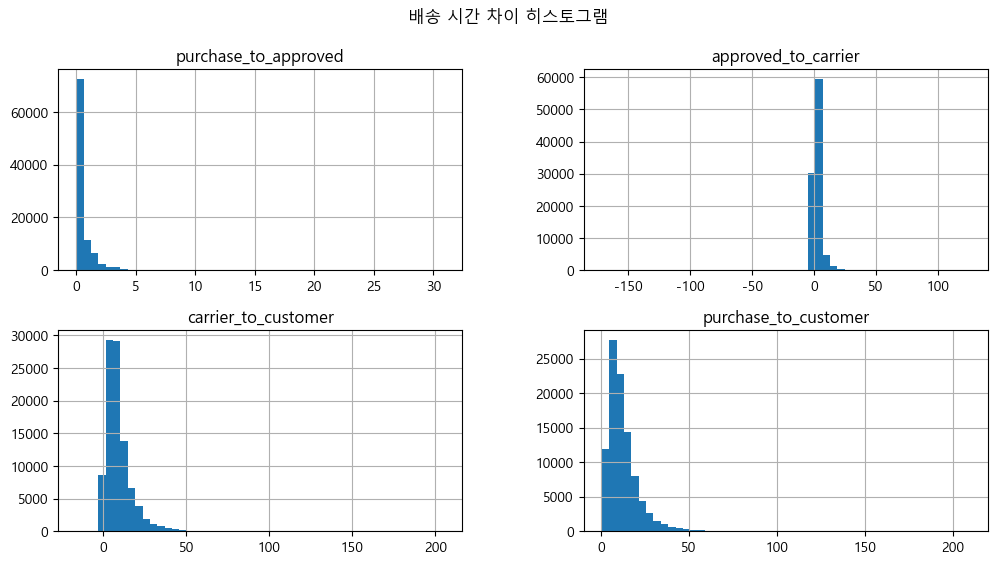

=== Z-score 기준 이상치 비율 (|Z|>3) ===
purchase_to_approved: 2.26%
approved_to_carrier: 1.92%
carrier_to_customer: 1.64%
purchase_to_customer: 1.63%

=== IQR 기준 이상치 비율 ===
purchase_to_approved: 9.27%
approved_to_carrier: 5.80%
carrier_to_customer: 5.25%
purchase_to_customer: 5.08%


In [ ]:
# 이상치 탐지 시각화

# 1️⃣ 히스토그램 시각화
df_order[time_cols].hist(bins=50, figsize=(12,6))
plt.suptitle("배송 시간 차이 히스토그램")
plt.show()

# 2️⃣ 극단치 비율 계산
print("=== Z-score 기준 이상치 비율 (|Z|>3) ===")
for col in time_cols:
    z = zscore(df_order[col].dropna())
    outlier_ratio = (abs(z) > 3).mean() * 100
    print(f"{col}: {outlier_ratio:.2f}%")

# 3️⃣ IQR 기반 이상치 비율 계산
print("\n=== IQR 기준 이상치 비율 ===")
for col in time_cols:
    data = df_order[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    iqr_outlier_ratio = ((data < lower_bound) | (data > upper_bound)).mean() * 100
    print(f"{col}: {iqr_outlier_ratio:.2f}%")

In [ ]:
# # 이상치 처리: IQR

# # IQR 이상치 제거 함수
# def remove_iqr_outliers(df, cols):
#     df_clean = df.copy()
    
#     for col in cols:
#         data = df_clean[col].dropna()
#         Q1 = data.quantile(0.25)
#         Q3 = data.quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         # IQR 범위를 벗어난 행 제거
#         df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        
#         print(f"{col}: 제거 후 데이터 수 = {len(df_clean)}")
    
#     return df_clean

# # 실행
# df_order = remove_iqr_outliers(df_order, time_cols)

purchase_to_approved: 제거 후 데이터 수 = 87526
approved_to_carrier: 제거 후 데이터 수 = 82605
carrier_to_customer: 제거 후 데이터 수 = 78274
purchase_to_customer: 제거 후 데이터 수 = 77032


In [ ]:
# time_cols = ["purchase_to_approved", "approved_to_carrier", "carrier_to_customer", "purchase_to_customer"]

def remove_iqr_outliers_combined(df, cols):
    # 빈 마스크(mask) 생성
    combined_mask = pd.Series([True] * len(df), index=df.index)
    
    for col in cols:
        data = df[col].dropna()
        if data.empty:
            print(f"Warning: No data to analyze for {col}. Skipping.")
            continue
            
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 각 컬럼별로 이상치 범위를 벗어나지 않는 행을 True로 하는 마스크 생성
        col_mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
        
        # 최종 마스크에 현재 컬럼의 마스크를 결합 (AND 연산)
        # combined_mask = combined_mask & col_mask
        # 결측치가 있는 경우를 고려하여 `.fillna(False)`를 사용하면 더 안전합니다.
        combined_mask &= col_mask.fillna(True)
        
        print(f"'{col}'에 대한 마스크 생성 완료.")
        
    # 최종 마스크를 사용하여 df_clean 생성
    df_clean = df[combined_mask].copy()
    
    initial_len = len(df)
    removed_count = initial_len - len(df_clean)
    
    print(f"\n총 이상치 제거: {initial_len} -> {len(df_clean)} (제거된 행 수: {removed_count})")
    
    return df_clean

# 실행
df_order = remove_iqr_outliers_combined(df_order, time_cols)

# 최종 df_order 데이터프레임의 상태 확인
print("\n[최종 df_order의 기초 통계량]")
print(df_order[time_cols].describe())

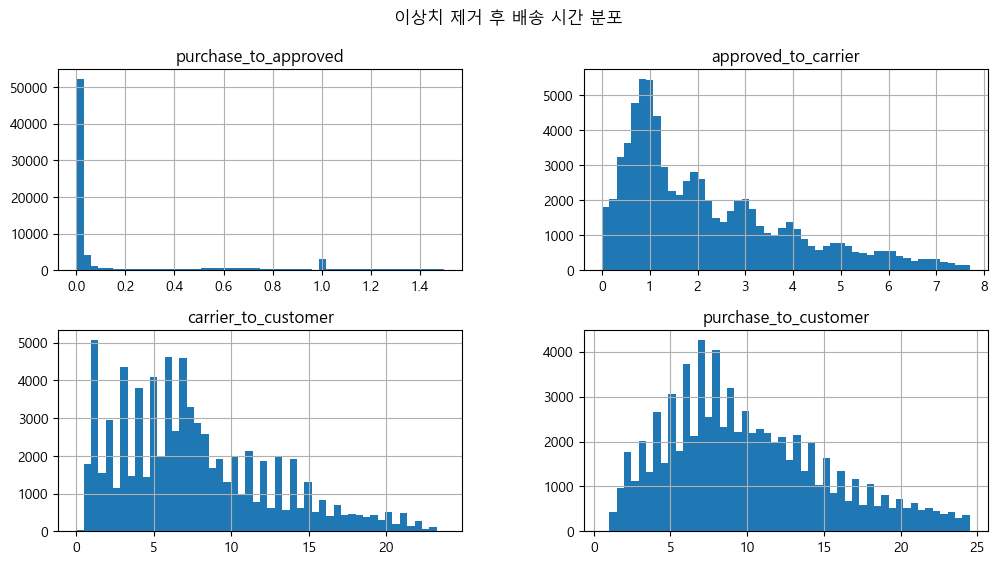

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,96461,96461,96461,96461,96461,96461,96461,96461
unique,96461,96461,2,95939,88272,80100,95649,445
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-08-02 12:06:09,2018-02-27 04:31:10,2018-05-09 15:48:00,2017-06-19 18:47:51,2017-12-20 00:00:00
freq,1,1,96455,3,9,47,3,507


In [ ]:
# 이상치 제거 후 배송 시간 분포 확인
df_order[time_cols].hist(bins=50, figsize=(12,6))
plt.suptitle("이상치 제거 후 배송 시간 분포")
plt.show()

# 이상치 확인 후 도메인 규칙 기반 제거
df_order = df_order[df_order['approved_to_carrier'] >= 0]
df_order = df_order[df_order['carrier_to_customer'] >= 0]

# 기초 통계 확인
df_order[time_cols].describe()

df_order.describe()
# df_order = df_deliverd_clean


In [ ]:
# 과제 1

